# **Task 1**

could also be found at:
https://colab.research.google.com/drive/1nHbQy5w5uo4ohoiGsw-qdYC9h4eBNE7v?usp=sharing

## Imports and helper functions

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 11.7,8.27
rcParams.update({'font.size': 22})

In [ ]:
!pip install kafka-python
import time
from kafka import KafkaConsumer
from numpy import nan
from numpy import inf
import ast
import pickle
import matplotlib.ticker as ticker

In [ ]:
'''
This function helps clean the data by dropping any records/raws that have NaN or infinity values
'''
def data_clean(df):
    df = df.dropna()
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
'''
This function contains a loop that is called within the dynamic solution, responsible for pulling the data from the dynamic source,
iterating through them, and preprocessing them accordingly. After that, the function is also responsible for appending the pulled packets to the 
dataset for further prediction.
The function takes the number of packets in the sliding window (10K packets in this case), and returns a dataframe representing the dataset ready for prediction.
'''
def consumer_loop(iterations):
  df= pd.DataFrame()
  i = 0
  arr = []
  for message in consumer:
      data_packet=message.value
      data_packet = data_packet.decode("utf-8")
      data_packet = data_packet.replace('-inf', 'inf * -1)')
      x = eval(data_packet)
      arr.append(x)
      if i == iterations-1:
          break
      i += 1

  df = df.append(arr,ignore_index=True)
  df.columns = df.columns.str.replace(' ', '')
  df = df[cols_to_keep]
  df['Label'] = enc.transform(df['Label'])
  df = data_clean(df)  
  df[df.columns[:-1]] = rs.transform(df[df.columns[:-1]])
  return df 

## Loading dataset

In [ ]:
'''
Loading the dataset from a private repo in my own github account, (Note: the repository is private. It is only used for storage. the given dataset is not shared anywhere 
on the internet whatsoever) to avoid uploading the dataset into google colab runtime session each time the runtime is recycled.
'''
data = pd.read_csv('https://raw.githubusercontent.com/NourhanWagdi/Kafka/main/cicids_static_data.csv?token=AJY3Q34Q2JCEL6WW27Y5V4TBT2HPG')
data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,159,2,2,68,266,34,34,34.0,0.0,133,133,133.0,0.0,2.100629e+06,25157.232700,53.00000,90.066642,157,1,1,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0,0,0,40,40,12578.616350,12578.616350,34,133,73.6,54.224533,2940.3,0,0,0,0,0,0,0,0,1,92.00,34.0,133.0,40,0,0,0,0,0,0,2,68,2,266,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,51673,2,2,90,166,45,45,45.0,0.0,83,83,83.0,0.0,4.954231e+03,77.409866,17224.33333,29827.358290,51666,3,4,4.0,0.0,4,4,3,3.0,0.0,3,3,0,0,0,0,64,64,38.704933,38.704933,45,83,60.2,20.813457,433.2,0,0,0,0,0,0,0,0,1,75.25,45.0,83.0,64,0,0,0,0,0,0,2,90,2,166,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,7496,43,1,1,0,6,0,0,0.0,0.0,6,6,6.0,0.0,1.395349e+05,46511.627910,43.00000,0.000000,43,43,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.0,3.464102,12.0,0,0,0,1,0,0,0,0,1,3.00,0.0,6.0,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,ATTACK
3,46564,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.885250,61.00000,0.000000,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.000000,0.0,0,0,0,0,1,1,0,0,1,9.00,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,440,307,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,80,69,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,28985.507250,69.00000,0.000000,69,69,69,69.0,0.0,69,69,0,0.0,0.0,0,0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.0,0.000000,0.0,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Data preprocessing

In [ ]:
'''
Encoding the label into a numeric form so it would be machine-readable
'''
enc = LabelEncoder()
data['Label'] = enc.fit_transform(data['Label'])

In [ ]:
'''
Removing spaces everywhere in column names
'''
data.columns = data.columns.str.replace(' ', '')

In [ ]:
'''
Drop all columns with all 0s
'''
data = data.loc[:, (data != 0).any(axis=0)]
data.head(5)

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,53,159,2,2,68,266,34,34,34.0,0.0,133,133,133.0,0.0,2.100629e+06,25157.232700,53.00000,90.066642,157,1,1,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0,40,40,12578.616350,12578.616350,34,133,73.6,54.224533,2940.3,0,0,0,0,0,0,0,0,1,92.00,34.0,133.0,40,2,68,2,266,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,1
1,53,51673,2,2,90,166,45,45,45.0,0.0,83,83,83.0,0.0,4.954231e+03,77.409866,17224.33333,29827.358290,51666,3,4,4.0,0.0,4,4,3,3.0,0.0,3,3,0,0,64,64,38.704933,38.704933,45,83,60.2,20.813457,433.2,0,0,0,0,0,0,0,0,1,75.25,45.0,83.0,64,2,90,2,166,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,1
2,7496,43,1,1,0,6,0,0,0.0,0.0,6,6,6.0,0.0,1.395349e+05,46511.627910,43.00000,0.000000,43,43,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.0,3.464102,12.0,0,0,0,1,0,0,0,0,1,3.00,0.0,6.0,40,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46564,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.885250,61.00000,0.000000,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.000000,0.0,0,0,0,0,1,1,0,0,1,9.00,6.0,6.0,20,1,6,1,6,440,307,0,20,0.0,0.0,0,0,0.0,0.0,0,0,1
4,80,69,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,28985.507250,69.00000,0.000000,69,69,69,69.0,0.0,69,69,0,0.0,0.0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.0,0.000000,0.0,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,40,2,0,0,0,251,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,1


In [ ]:
cols_to_keep = data.columns

In [ ]:
'''
The data is cleaned using the data_clean() function defined previously, then a robust scaler is used to scale features using statistics that are robust to outliers.
'''
data_cleaned = data_clean(data)
rs = RobustScaler()
data_cleaned[data_cleaned.columns[:-1]] = rs.fit_transform(data_cleaned[data_cleaned.columns[:-1]])
X = data_cleaned[data_cleaned.columns[:-1]]
y = data_cleaned['Label']

## Data splitting

In [ ]:
'''
Splitting the data into training and testing portions using 60% for training and 40% for testing.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (15107, 70)  | Test set Shape: (10072, 70)


##First learning algorithm (Static) - Decision tree

In [ ]:
data['Label'].value_counts()

1    22744
0     2447
Name: Label, dtype: int64

In [ ]:
'''
Decision tree classifier is defined, hyperparameters are chosen as per the following:
- for the splitter parameter, 'best' was chosen so the model would take the feature with the highest importance.
- for the class_weight attribute, higher weights were associated with the class with less frequency. (the number of samples for the 0 class is almost 11% of the 1 class)
'''
clf1 = DecisionTreeClassifier(splitter='best', class_weight={0: 11, 1: 1})
clf1.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 11, 1: 1})

In [ ]:
'''
In the following two cells, predictions are made and a classification report with all the findings is shown.
'''
y_pred1 = clf1.predict(X_test)

In [ ]:
print('F1 Score:',metrics.f1_score(y_test, y_pred1))
print('Classification report:')
print(classification_report(y_test, y_pred1))

F1 Score: 0.9979595213147301
Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1007
         1.0       1.00      1.00      1.00      9065

    accuracy                           1.00     10072
   macro avg       0.99      0.99      0.99     10072
weighted avg       1.00      1.00      1.00     10072



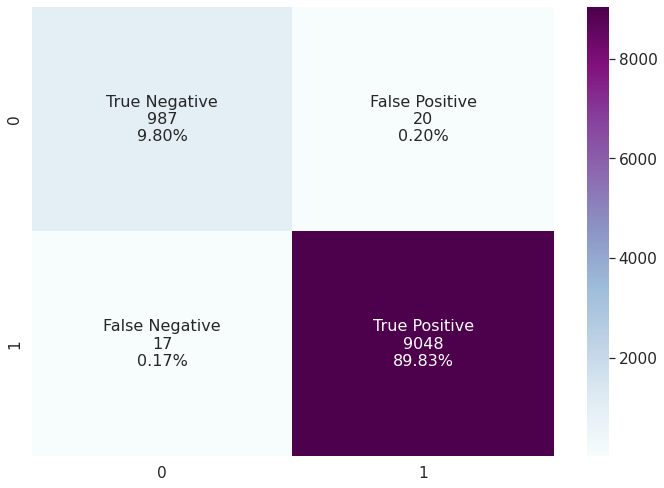

In [ ]:
'''
The below code is responsible for showing the confusion matrix for the model, in which the numbers of correct and incorrect predictions are summarized in the form
of a heatmap using seaborn.
'''
cm = confusion_matrix(y_test, y_pred1)

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=labels, fmt='', cmap='BuPu', annot_kws={"size": 16})
plt.show()

##Second learning algorithm (Static) - Support vector machine

In [ ]:
'''
Support vector machines classifier is defined, hyperparameters are chosen as per the following:
- for the kernel parameter, 'rbf' or Radial Basis Function kernel was chosen becasue it's popular for overcoming the space complexity problem,
as it only needs to store the support vectors during training and not the whole dataset.
- for the class_weight attribute, higher weights were associated with the class with less frequency. (as the number of samples for the 0 class is almost 11% of the 1 class)
'''
clf2 = svm.SVC(kernel="rbf", class_weight={0: 11, 1: 1})
clf2.fit(X_train, y_train)

SVC(class_weight={0: 11, 1: 1})

In [ ]:
'''
In the following two cells, predictions are made and a classification report with all the findings is shown.
'''
y_pred2 = clf2.predict(X_test)

In [ ]:
print("F1 Score:",metrics.f1_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

F1 Score: 0.9551951180343664
              precision    recall  f1-score   support

         0.0       0.69      0.31      0.43      1007
         1.0       0.93      0.98      0.96      9065

    accuracy                           0.92     10072
   macro avg       0.81      0.65      0.69     10072
weighted avg       0.90      0.92      0.90     10072



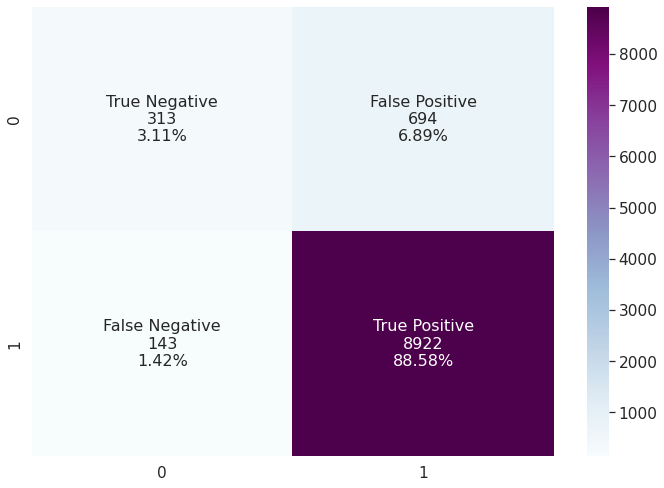

In [ ]:
'''
The below code is responsible for showing the confusion matrix for the model, in which the numbers of correct and incorrect predictions are summarized in the form
of a heatmap using seaborn.
'''

cm2 = confusion_matrix(y_test, y_pred2)

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm2.flatten()/np.sum(cm2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.4)
sns.heatmap(cm2, annot=labels, fmt='', cmap='BuPu', annot_kws={"size": 16})
plt.show()

## Dynamic solution

In [ ]:
'''
The following is an instantiation of the consumer that consumes records from the Kafka cluster. 
'''
consumer = KafkaConsumer(
    'task1',
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [ ]:
with open('classifier', 'wb') as file1:
    pickle.dump(clf1, file1)
with open('classifier' , 'rb') as file2:
    stat = pickle.load(file2)
with open('classifier' , 'rb') as file3:
    dyn = pickle.load(file3)

In [ ]:
dyn_data = data_cleaned 
PACKET_MAX = 100000
sliding_window = 10000
steps = PACKET_MAX // sliding_window
all_scores_stat = []
all_scores_dyn = []
data = []
data = pd.DataFrame()

for n in range(steps):          #for loop that takes number of iterations (10 iterations since the batch size is 10K)

  #calling the consumer_loop function to pull and preprocess the data packets from the Kafka server
  df_consumer = consumer_loop(sliding_window)
  
  #separating labels from the rest of the features
  X_dyn = dyn_data.drop(['Label'], axis=1)
  y_dyn = dyn_data['Label']

  #predictions are made for further evaluation. Then, f-1 scores are printed for each iteration
  y_pred_dyn = dyn.predict(X_dyn)
  y_pred_stat = stat.predict(X_dyn)
  f1_iter_dyn = metrics.f1_score(y_dyn, y_pred_dyn)
  f1_iter_stat = metrics.f1_score(y_dyn, y_pred_stat)

  all_scores_dyn.append(f1_iter_dyn)
  all_scores_stat.append(f1_iter_stat)

  #this line of code deletes 10K rows from the dataset
  dyn_data = dyn_data.iloc[sliding_window: , :]

  #while this line appends the new data (10K) pulled from the Kafka server to the dataset
  dyn_data = dyn_data.append(df_consumer)

  #creating new X and y ready to be fit into the model
  X_dyn_new = dyn_data.drop(['Label'], axis=1)
  y_dyn_new = dyn_data['Label']

  #the chosen model here was the decision tree as it provided overall better performance
  dyn.fit(X_dyn_new,y_dyn_new)

In [ ]:
print(all_scores_stat)
print(all_scores_dyn)

[0.9991863661352391, 0.9985696996369239, 0.9977266206105017, 0.9971303695201095, 0.9969592808038076, 0.9972862658576944, 0.9975776260735522, 0.9978845306302335, 0.9977081405086164, 0.9975934471110326]
[0.9991863661352391, 1.0, 1.0, 1.0, 0.999977944906376, 0.9999779147065969, 0.999977969200943, 1.0, 1.0, 1.0]


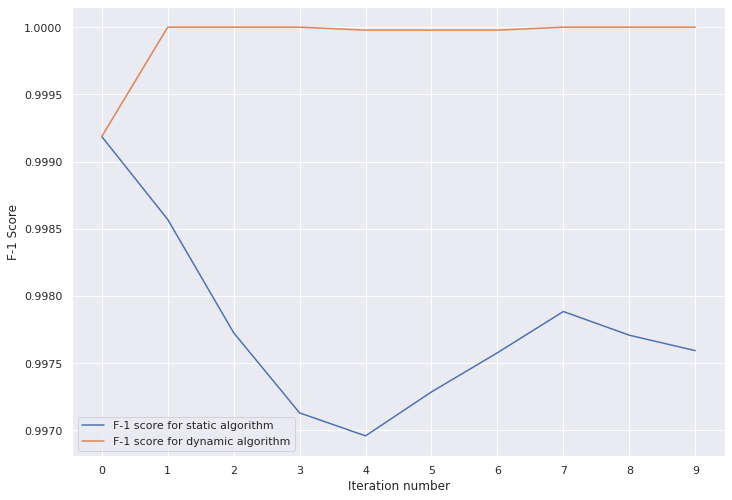

In [ ]:
plt.plot(all_scores_stat)
plt.plot(all_scores_dyn)
plt.xlabel('Iteration number')
plt.ylabel('F-1 Score')
plt.xticks(range(0,10))
plt.legend(['F-1 score for static algorithm','F-1 score for dynamic algorithm'])
plt.show()